In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time

## Problem Information
From Kaggle -
Santa has exciting news! For 100 days before Christmas, he opened up tours to his workshop. Because demand was so strong, and because Santa wanted to make things as fair as possible, he let each of the 5,000 families that will visit the workshop choose a list of dates they'd like to attend the workshop.

Now that all the families have sent Santa their preferences, he's realized it's impossible for everyone to get their top picks, so he's decided to provide extra perks for families that don't get their preferences. In addition, Santa's accounting department has told him that, depending on how families are scheduled, there may be some unexpected and hefty costs incurred.

Santa needs the help of the Kaggle community to optimize which day each family is assigned to attend the workshop in order to minimize any extra expenses that would cut into next years toy budget! Can you help Santa out?

The total number of people attending the workshop each day must be between 125 - 300; if even one day is outside these occupancy constraints, the submission will error and will not be scored.

Our notes -
We are given each family's 10 preferred days to visit Santa. If the family does not visit Santa on the first day, then Santa incurs a preference cost to accomodate them. There is also an accounting cost that penalizes large variations in the number of people per day. 

Using the family's first choice as a starting point provides a good method for initializing the optimization. This is because the more families that are given their top choice, the lower the overall cost will be. 

A first thing to examine is the distribution of the preferred days (by number of people).

In [2]:
family_preferences = pd.read_csv("../Data/family_data.csv", index_col= "family_id")

In [3]:
family_preferences.head()
print(family_preferences.shape[1])

11


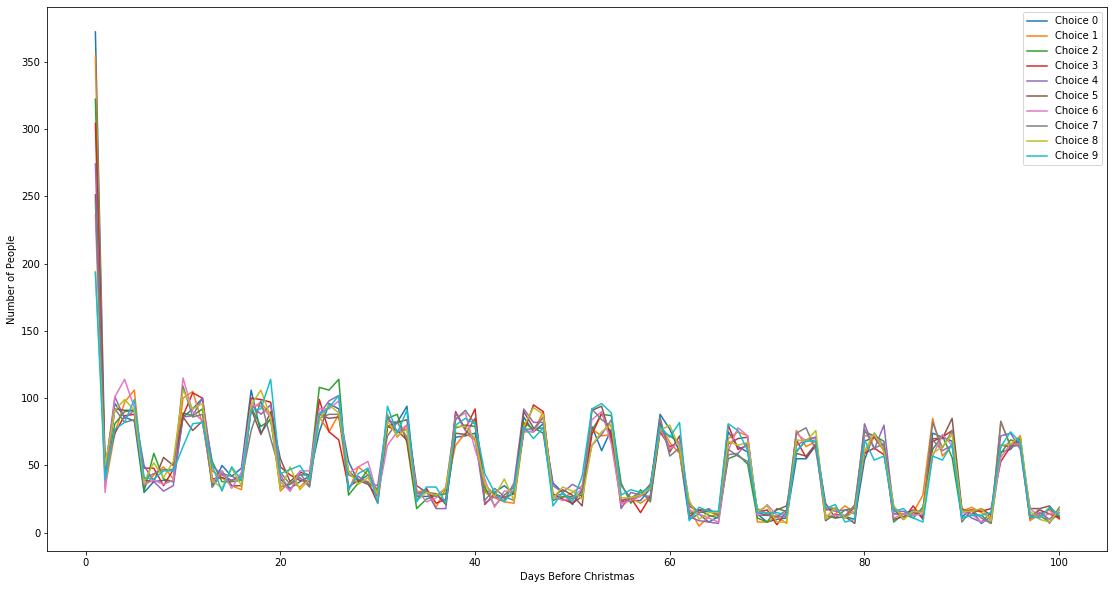

In [4]:
plt.figure(figsize=(19, 10))
for i in range(family_preferences.shape[1] - 1):
    choice_count = family_preferences.iloc[:,i].value_counts().sort_index()
    plt.plot(choice_count, label = "Choice %s" % i)
plt.legend()
plt.xlabel("Days Before Christmas")
plt.ylabel("Number of People")
plt.show()

Here, day 0 is Christmas Day, so many families want to visit on Christmas Eve. For our heuristic approach, we will need to incorporate some penalty for being on Day 1. Since so many people want to attend Santa's workshop on Day 1, it will be beneficial to give them their 2nd choice. 

Another note is that there are spikes on the Weekends, and lower values on weekdays. So another challenge will be ensuring that 125 people are attending on weekdays, especially far from Christmas.

Next, let's look at the number of people that request each day. The previous figure only examined families, but families have different number of people.

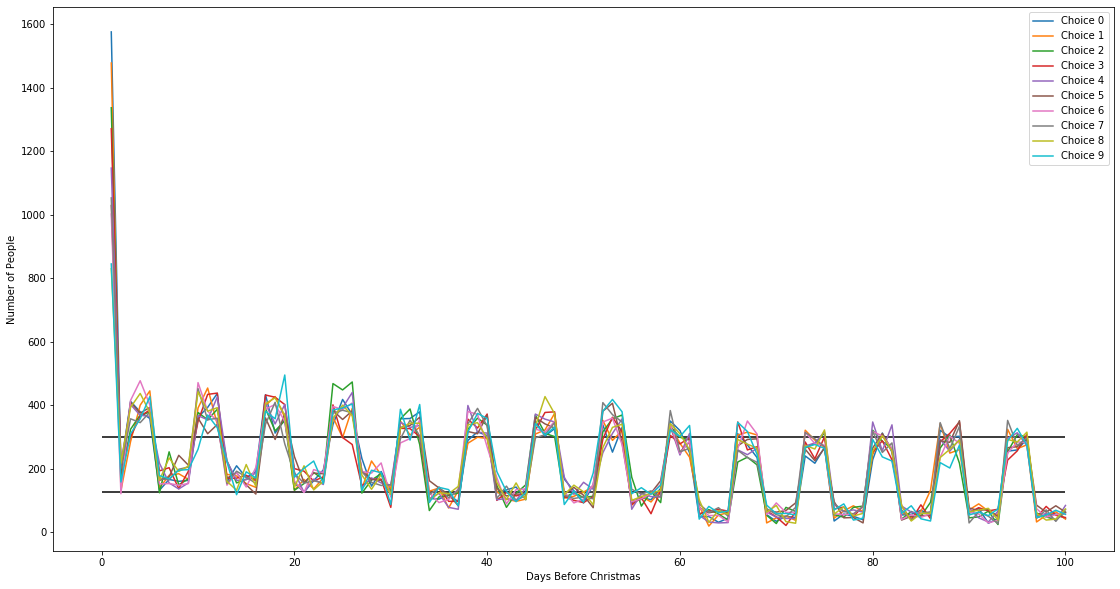

In [5]:
plt.figure(figsize=(19, 10))
for i in range(family_preferences.shape[1] - 1):
    choice_count = family_preferences.iloc[:,[i,-1]]
    choice_count = choice_count.groupby(choice_count.columns[0]).sum()    
    plt.plot(choice_count, label = "Choice %s" % i)
plt.legend()
plt.xlabel("Days Before Christmas")
plt.ylabel("Number of People")
plt.hlines(300, 0, 100, colors = "k")
plt.hlines(125, 0, 100, colors = "k")
plt.show()

The two lines denote 125 and 300 people, respectively. For each day, the total number of people must be between these two lines. Let's plot only the first choice and see how it is distributed.

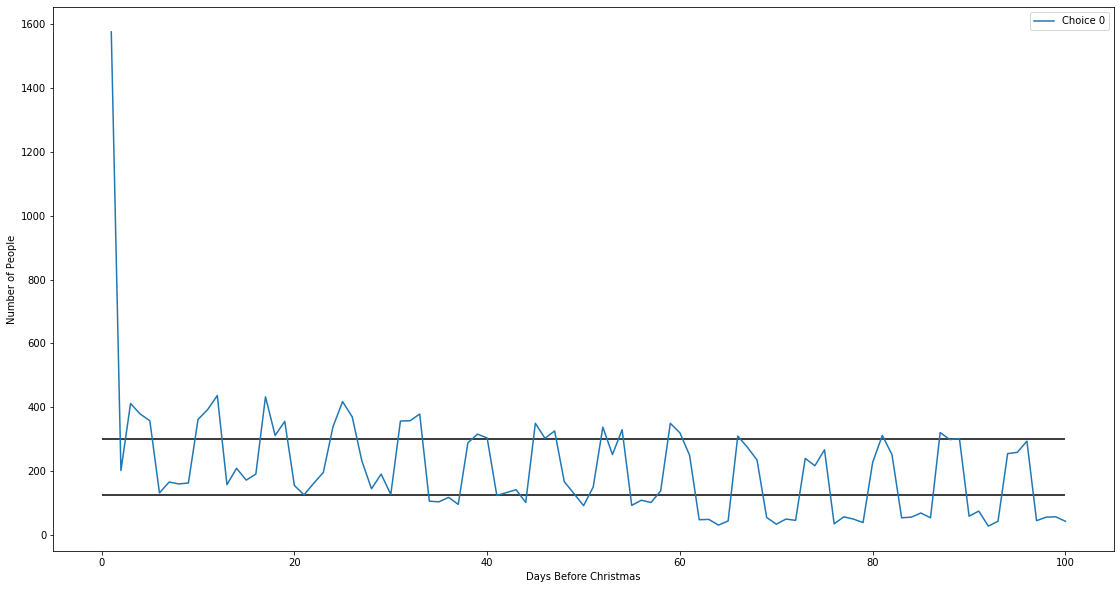

In [6]:
plt.figure(figsize=(19, 10))
for i in range(1):
    choice_count = family_preferences.iloc[:,[i,-1]]
    choice_count = choice_count.groupby(choice_count.columns[0]).sum()    
    plt.plot(choice_count, label = "Choice %s" % i)
plt.legend()
plt.xlabel("Days Before Christmas")
plt.ylabel("Number of People")
plt.hlines(300, 0, 100, colors = "k")
plt.hlines(125, 0, 100, colors = "k")
plt.show()

We have some days that have the required number of people, but days closer to Christmas tend to have more than 300 people and days far away from Christmas tend to have fewer people. In total, there are 21003 people, so an average of 210.03 per day. 

In [7]:
print(sum(choice_count.iloc[:,0]))

21003


## Helper Functions

Two helper functions are defined below to help for heuristic evaluation

1) Function to evalutate the cost quickly. This code was provided by Kaggle for the competition and was much faster  than the code we initially developed for calculating the cost

2) Function to get to a feasible point quickly. Instead of starting at a random location, it is favorable to start with each family's preferred day to visit. However, this leads to some days having too many or too few people. We fix this by randomly assigning people on days with too many people to days with fewer people. Another possible starting point would be too randomly assign people to individual days, but we believe that this starting point will be more beneficial.

In [8]:
def get_cost(pred, fs_d, ch_d):
    
    days = list(range(100,0,-1))
    
    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(pred):

        # Using our lookup dictionaries to make simpler variable names
        n = fs_d[f]
        choice_0 = ch_d['choice_0'][f]
        choice_1 = ch_d['choice_1'][f]
        choice_2 = ch_d['choice_2'][f]
        choice_3 = ch_d['choice_3'][f]
        choice_4 = ch_d['choice_4'][f]
        choice_5 = ch_d['choice_5'][f]
        choice_6 = ch_d['choice_6'][f]
        choice_7 = ch_d['choice_7'][f]
        choice_8 = ch_d['choice_8'][f]
        choice_9 = ch_d['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > 300) or (v < 125):
            penalty += 100000000

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    penalty += accounting_cost

    return penalty

In [9]:
def get_days_over_n(df, n):
    df = df.groupby(df.columns[-1]).sum().sort_values(by = "n_people")
    return df.index[df['n_people'] > n].tolist()

def get_days_under_n(df, n):
    df = df.groupby(df.columns[-1]).sum().sort_values(by = "n_people")
    return df.index[df['n_people'] < n ].tolist()

def check_days(df):
    return len(get_days_over_n(df, 300)) + len(get_days_under_n(df, 125))

def greedy_random_assignment(pred_df, eps):
    # Idea is to initialize all families with their first choice and then randomly assign families
    # on days where there are too many people (i.e. over 300) with preference towards assigning them to days
    # with less than 125 people.
    num_day_list = 1
    
    # Find an initial assignment that is feasible
    while num_day_list > 0:
        days_over = get_days_over_n(pred_df, 300)
        days_under = get_days_under_n(pred_df, 125)
        
        # If there are no days with over 300 people, take people from days with more than 250 people
        if ((len(days_over) == 0) & (len(days_under) > 0)):
            days_over = get_days_over_n(pred_df, 250)
            
        # If there are no days with under 125 people, give people to days with less than 175 people
        if ((len(days_over) > 0) & (len(days_under) == 0)):
            days_under = get_days_under_n(pred_df, 175)           
            
        for day in days_over:
            fam_assigned = pred_df.index[pred_df['assigned_day'] == day].tolist()
            for fam in fam_assigned:
                if np.random.random() < eps:
                    pred_df.iloc[fam, -1] = np.random.choice(days_under)    
        
        num_day_list = check_days(pred_df)
    return pred_df

## Heuristic 1: Random Search

For our first heuristic, we initially assign all families to their first choice. We then probabilistically randomly assign families on days with more than 300 people to days with less than 125 people. In this heuristic, we continue moving people until a feasible solution is found. Once a feasible solution is found, we use stochastic 2-opt to successively find new feasible solutions. We move all people assigned from day j to day k and vice versa. Since the original solution was feasible, each stochastic 2-opt is also guaranteed to be feasible.

This solution will not be great, but provides a baseline to compare future heuristics. An additional point to note is that the optimal cost for this problem is 68888.04.

In [10]:
def random_search(assign_df, epsilon, num_iterations, swap_rate, fam_size_dict, choice_dict, greedy):
    
    # Get an initial feasible assignment
    if greedy:
        assign_df = greedy_random_assignment(pred_df=assign_df, eps=epsilon)
    best_cost = 10e10
    for i in range(num_iterations):
        for j in range(1,100):
            # Probabilistic 2-opt
            if np.random.random() < swap_rate:
                
                # Assign all people on day j to another day k and vice versa
                other_days = [x for x in range(1,101) if x != j]
                new_day = np.random.choice(other_days)
                assign_df = assign_df.replace({j:new_day, new_day:j})
                
                # Only want to accept the swap if it reduces the overall cost
                new_cost = get_cost(pred = assign_df["assigned_day"].tolist(), fs_d = fam_size_dict, ch_d = choice_dict)
                if new_cost < best_cost:
                    best_df = assign_df.copy(deep=True)
                    best_cost = new_cost
                else:
                    # Reverse the assignment
                    assign_df = assign_df.replace({j:new_day, new_day:j})     
    return best_df, best_cost

## Heuristic 1(a): Random Search Family

In [11]:
def random_search_family(assign_df, epsilon, num_iterations, swap_rate, fam_size_dict, choice_dict, greedy):
    
    # Get an initial feasible assignment
    if greedy:
        assign_df = greedy_random_assignment(pred_df=assign_df, eps=epsilon)
    assigned_list = assign_df["assigned_day"].tolist()
    best_cost = 10e10
    for i in range(num_iterations):
        for j in range(1,5000):
            # Probabilistic 2-opt
            if np.random.random() < swap_rate:
                
                cur_day = assigned_list[j]
                
                # Assign all people on day j to another day k and vice versa
                other_days = [x for x in range(1,101) if x != cur_day]
                new_day = np.random.choice(other_days)
                assigned_list[j] = new_day
                
                # Only want to accept the swap if it reduces the overall cost
                new_cost = get_cost(pred = assigned_list, fs_d = fam_size_dict, ch_d = choice_dict)
                if new_cost < best_cost:
                    best_assignment = assigned_list
                    best_cost = new_cost
                else:
                    # Reverse the assignment
                    assigned_list[j] = cur_day       
                    
    return best_assignment, best_cost

## Heuristic 2: Guided Local Search

Idea is to give preference to family choices. Try to put them on the best day to minimize overall cost.

In [12]:
def guided_local_search(assign_df, epsilon, num_iterations, fam_size_dict, choice_dict, greedy, num_fam_swap):
    
    # Get an initial feasible solution
    if greedy:
        assign_df = greedy_random_assignment(pred_df=assign_df, eps=epsilon)
    
    # Initialize the assignment and cost based on the feasible solution
    best_assignment = assign_df["assigned_day"].tolist()
    best_cost = get_cost(pred = best_assignment, fs_d = fam_size_dict, ch_d = choice_dict)
    for i in range(num_iterations):
        
        # I just chose to swap 100 families each iteration. This could also be probabilistic
        for j in range(num_fam_swap):
            
            # Pick a random family
            family = np.random.choice(range(5000))
            for pick in range(10):
                
                # Try to put them on the preferred day
                choice = choice_dict[f'choice_{pick}'][family]
                
                # If they are already on a day they choose, break out of the loop. No improvement can be found
                if choice == best_assignment[family]:
                    break
                
                temp_assignment = best_assignment.copy()
                temp_assignment[family] = choice
                new_cost = get_cost(pred = temp_assignment, fs_d = fam_size_dict, ch_d = choice_dict)
                if new_cost < best_cost:
                    best_assignment = temp_assignment.copy()
                    best_cost = new_cost
                    
                    # If a new best cost is found, there is no need to keep checking their choices.
                    # Giving them a less preferred choice will increase cost
                    break
    return best_assignment, best_cost

## Heuristic 3: Genetic Algorithm

In [13]:
def genetic_algorithm(population_size, assign_df, epsilon, fam_size_dict, choice_dict, parents_count, mutation_rate, num_iter, family_matrix):
    
    # Initial population has 5000 entries, one for each family
    population = np.zeros((population_size, 5000))
    new_population = np.zeros((population_size, 5000))
    fitness = np.zeros((population_size, 1))
    cumulative_fitness = np.zeros((population_size, 1))
    best_cost = 10e10
    
    for iteration in range(num_iter):
        if iteration == 0:

            # Initialize population and fitness scores
            for i in range(population_size):
                temp_df = assign_df.copy(deep = True)
                temp_assignment = greedy_random_assignment(pred_df=temp_df, eps=epsilon)["assigned_day"]
                population[i,:] = temp_assignment
                fitness[i] = get_cost(pred=temp_assignment, fs_d=fam_size_dict, ch_d=choice_dict)
        else:
            # Add parents to new population
            for i in range(parents_count):
                new_population[i,:] = population[new_parents[i], :]

            # Crossover to make offspring: Using 2 point crossover
            for i in range(parents_count, population_size):
                parent_1 = np.random.choice(range(parents_count))
                parent_2 = np.random.choice([x for x in range(parents_count) if x != parent_1])
                crossover_1 = np.random.choice(range(1,4999))
                crossover_2 = np.random.choice([x for x in range(1,4999) if x != crossover_1])
                if crossover_1 > crossover_2:
                    crossover_2, crossover_1 = crossover_1, crossover_2
                new_population[i, :crossover_1] = new_population[parent_1, :crossover_1]
                new_population[i, crossover_1:crossover_2] = new_population[parent_2, crossover_1:crossover_2]
                new_population[i, crossover_2:] = new_population[parent_1, crossover_2:]

            # Mutation: Calculate number of mutations and randomly apply then
            num_mutations = mutation_rate * population_size * 5000
            for _ in range(int(num_mutations)):
                fam_mutate = np.random.choice(range(5000))
                
                # Assign a decreasing probability that their worse choices are selected
                choice_prob = [0.181818182,0.163636364,0.145454545,0.127272727,0.109090909,0.090909091,0.072727273,0.054545455,0.036363636,0.018181818]
                mutated_choice = np.random.choice(range(10), size = 1, p = choice_prob)
                new_population[np.random.choice(range(population_size)), fam_mutate] = family_matrix.iloc[fam_mutate, mutated_choice]
                
            # Calculate fitness
            for i in range(population_size):
                fitness[i] = get_cost(pred=new_population[i,:].astype(int), fs_d=fam_size_dict, ch_d=choice_dict)
            
            # Assign new population to population
            population = new_population
    
        # Take the top n parents for the next population. 
        new_parents = np.argsort(-fitness.ravel())[-parents_count:]
        if min(fitness.ravel()) < best_cost:
            best_cost = min(fitness.ravel())
        
    return best_cost



## Data import

In [14]:
# Data importing
family_data = pd.read_csv("../Data/family_data.csv", index_col= "family_id")
initial_submission = pd.read_csv("../Data/sample_submission.csv")
initial_allocation = pd.concat([initial_submission, family_data.iloc[:, -1], family_data.iloc[:,0]], axis = 1)
initial_allocation = initial_allocation[['family_id', 'n_people', 'choice_0']]
initial_allocation = initial_allocation.rename(columns={"choice_0": "assigned_day"})


# Kaggle provided a cost function, which is very fast. Need these values to use it.
family_size_dict = family_data[['n_people']].to_dict()['n_people']
cols = [f'choice_{i}' for i in range(10)]
family_choice_dict = family_data[cols].to_dict()

## Testing Heuristics



### Testing effect of swap rate for Greedy Random Search 

In [26]:
swap_rate_list = [0.1, 0.3, 0.5] # put swap rates to test here
for swap_rate in swap_rate_list:
    worst_cost = 0
    best_cost = 10e10
    worst_time = 0
    best_time = 10e10
    for test in range(10):

        # Run Random Search
        start = time.time()
        assignment, cost = random_search(assign_df=initial_allocation,
                                     epsilon=0.5,
                                     num_iterations = 1000,
                                     swap_rate = swap_rate,
                                     fam_size_dict = family_size_dict,
                                     choice_dict = family_choice_dict,
                                     greedy = True)
        end = time.time()
        print(f'Swap_Rate {swap_rate} Test {test} Finished')
        if test == 0:
            average_time = (end-start)
            average_cost = cost
        else:
            average_time = (average_time) + ((end-start)-average_time)/(test+1)
            average_cost = (average_cost) + ((cost)-average_cost)/(test+1)
        if (end-start) < best_time:
            best_time = (end-start)
        if (end-start) > worst_time:
            worst_time = (end-start)
        if cost < best_cost:
            best_cost = cost
        if cost > worst_cost:
            worst_cost = cost
    print("Swap Rate: %s" % swap_rate)
    print("Average Time: %s" % np.round(average_time,3))
    print("Best Time: %s" % np.round(best_time,3))
    print("Worst Time: %s" % np.round(worst_time,3))
    print("Average Cost: %s" % np.round(average_cost,2))
    print("Best Cost: %s" % np.round(best_cost,2))
    print("Worst Cost: %s" % np.round(worst_cost,2))

Swap_Rate 0.1 Test 0 Finished
Swap_Rate 0.1 Test 1 Finished
Swap_Rate 0.1 Test 2 Finished
Swap_Rate 0.1 Test 3 Finished
Swap_Rate 0.1 Test 4 Finished
Swap_Rate 0.1 Test 5 Finished
Swap_Rate 0.1 Test 6 Finished
Swap_Rate 0.1 Test 7 Finished
Swap_Rate 0.1 Test 8 Finished
Swap_Rate 0.1 Test 9 Finished
Swap Rate: 0.1
Average Time: 73.113
Best Time: 69.777
Worst Time: 76.584
Average Cost: 4171889.14
Best Cost: 4023319.09
Worst Cost: 4345254.77
Swap_Rate 0.3 Test 0 Finished
Swap_Rate 0.3 Test 1 Finished
Swap_Rate 0.3 Test 2 Finished
Swap_Rate 0.3 Test 3 Finished
Swap_Rate 0.3 Test 4 Finished
Swap_Rate 0.3 Test 5 Finished
Swap_Rate 0.3 Test 6 Finished
Swap_Rate 0.3 Test 7 Finished
Swap_Rate 0.3 Test 8 Finished
Swap_Rate 0.3 Test 9 Finished
Swap Rate: 0.3
Average Time: 235.852
Best Time: 218.58
Worst Time: 251.143
Average Cost: 4118066.98
Best Cost: 4001192.93
Worst Cost: 4252274.81
Swap_Rate 0.5 Test 0 Finished
Swap_Rate 0.5 Test 1 Finished
Swap_Rate 0.5 Test 2 Finished
Swap_Rate 0.5 Test 3 F

### Testing effect of swap rate for Greedy Random Search 1(a) Family

In [ ]:
swap_rate_list = [0.0025, 0.005, 0.01] # put swap rates to test here
for swap_rate in swap_rate_list:
    worst_cost = 0
    best_cost = 10e10
    worst_time = 0
    best_time = 10e10
    for test in range(10):

        # Run Random Search
        start = time.time()
        assignment, cost = random_search_family(assign_df=initial_allocation,
                                     epsilon=0.5,
                                     num_iterations = 1000,
                                     swap_rate = swap_rate,
                                     fam_size_dict = family_size_dict,
                                     choice_dict = family_choice_dict,
                                     greedy = True)
        end = time.time()
        print(f'Swap_Rate {swap_rate} Test {test} Finished')
        if test == 0:
            average_time = (end-start)
            average_cost = cost
        else:
            average_time = (average_time) + ((end-start)-average_time)/(test+1)
            average_cost = (average_cost) + ((cost)-average_cost)/(test+1)
        if (end-start) < best_time:
            best_time = (end-start)
        if (end-start) > worst_time:
            worst_time = (end-start)
        if cost < best_cost:
            best_cost = cost
        if cost > worst_cost:
            worst_cost = cost
    print("Swap Rate: %s" % swap_rate)
    print("Average Time: %s" % np.round(average_time,3))
    print("Best Time: %s" % np.round(best_time,3))
    print("Worst Time: %s" % np.round(worst_time,3))
    print("Average Cost: %s" % np.round(average_cost,2))
    print("Best Cost: %s" % np.round(best_cost,2))
    print("Worst Cost: %s" % np.round(worst_cost,2))

Swap_Rate 0.0025 Test 0 Finished
Swap_Rate 0.0025 Test 1 Finished
Swap_Rate 0.0025 Test 2 Finished
Swap_Rate 0.0025 Test 3 Finished
Swap_Rate 0.0025 Test 4 Finished
Swap_Rate 0.0025 Test 5 Finished
Swap_Rate 0.0025 Test 6 Finished
Swap_Rate 0.0025 Test 7 Finished
Swap_Rate 0.0025 Test 8 Finished
Swap_Rate 0.0025 Test 9 Finished
Swap Rate: 0.0025
Average Time: 99.614
Best Time: 98.047
Worst Time: 101.522
Average Cost: 2886304.46
Best Cost: 2851714.4
Worst Cost: 2924329.13
Swap_Rate 0.005 Test 0 Finished
Swap_Rate 0.005 Test 1 Finished
Swap_Rate 0.005 Test 2 Finished


### Testing effect of swap rate for Non - Greedy Random Search 1(a) Family

In [ ]:
swap_rate_list = [0.0025, 0.005, 0.01] # put swap rates to test here
for swap_rate in swap_rate_list:
    worst_cost = 0
    best_cost = 10e10
    worst_time = 0
    best_time = 10e10
    for test in range(10):

        # Run Random Search
        start = time.time()
        assignment, cost = random_search_family(assign_df=initial_submission,
                                     epsilon=0.5,
                                     num_iterations = 1000,
                                     swap_rate = swap_rate,
                                     fam_size_dict = family_size_dict,
                                     choice_dict = family_choice_dict,
                                     greedy = False)
        end = time.time()
        print(f'Swap_Rate {swap_rate} Test {test} Finished')
        if test == 0:
            average_time = (end-start)
            average_cost = cost
        else:
            average_time = (average_time) + ((end-start)-average_time)/(test+1)
            average_cost = (average_cost) + ((cost)-average_cost)/(test+1)
        if (end-start) < best_time:
            best_time = (end-start)
        if (end-start) > worst_time:
            worst_time = (end-start)
        if cost < best_cost:
            best_cost = cost
        if cost > worst_cost:
            worst_cost = cost
    print("Swap Rate: %s" % swap_rate)
    print("Average Time: %s" % np.round(average_time,3))
    print("Best Time: %s" % np.round(best_time,3))
    print("Worst Time: %s" % np.round(worst_time,3))
    print("Average Cost: %s" % np.round(average_cost,2))
    print("Best Cost: %s" % np.round(best_cost,2))
    print("Worst Cost: %s" % np.round(worst_cost,2))

### Testing effect of number of families swapped each iteration for Greedy Guided Local Search

In [ ]:
num_fam_swap_list = [50, 100, 200] # put number of families to swap each iteration here
for num_fam_swap in num_fam_swap_list:
    worst_cost = 0
    best_cost = 10e10
    worst_time = 0
    best_time = 10e10
    for test in range(10):

        # Run Random Search
        start = time.time()
        assignment, cost = guided_local_search(assign_df=initial_allocation,
                           num_iterations = 1000,
                           epsilon = 0.5,
                           fam_size_dict = family_size_dict,
                           choice_dict = family_choice_dict,
                           greedy = True,
                           num_fam_swap = num_fam_swap)
        end = time.time()
        print(f'Num_Fam_Swap {num_fam_swap} Test {test} Finished')
        if test == 0:
            average_time = (end-start)
            average_cost = cost
        else:
            average_time = (average_time) + ((end-start)-average_time)/(test+1)
            average_cost = (average_cost) + ((cost)-average_cost)/(test+1)
        if (end-start) < best_time:
            best_time = (end-start)
        if (end-start) > worst_time:
            worst_time = (end-start)
        if cost < best_cost:
            best_cost = cost
        if cost > worst_cost:
            worst_cost = cost
    print("Number of Families Swapped: %s" % num_fam_swap)
    print("Average Time: %s" % np.round(average_time,3))
    print("Best Time: %s" % np.round(best_time,3))
    print("Worst Time: %s" % np.round(worst_time,3))
    print("Average Cost: %s" % np.round(average_cost,2))
    print("Best Cost: %s" % np.round(best_cost,2))
    print("Worst Cost: %s" % np.round(worst_cost,2))

### Testing effect of number of families swapped each iteration for Non-Greedy Guided Local Search

In [ ]:
num_fam_swap_list = [50, 100, 200] # put number of families to swap each iteration here
for num_fam_swap in num_fam_swap_list:
    worst_cost = 0
    best_cost = 10e10
    worst_time = 0
    best_time = 10e10
    for test in range(10):

        # Run Random Search
        start = time.time()
        assignment, cost = guided_local_search(assign_df=initial_submission,
                           num_iterations = 1000,
                           epsilon = 0.5,
                           fam_size_dict = family_size_dict,
                           choice_dict = family_choice_dict,
                           greedy = False,
                           num_fam_swap = num_fam_swap)
        end = time.time()
        print(f'Num_Fam_Swap {num_fam_swap} Test {test} Finished')
        if test == 0:
            average_time = (end-start)
            average_cost = cost
        else:
            average_time = (average_time) + ((end-start)-average_time)/(test+1)
            average_cost = (average_cost) + ((cost)-average_cost)/(test+1)
        if (end-start) < best_time:
            best_time = (end-start)
        if (end-start) > worst_time:
            worst_time = (end-start)
        if cost < best_cost:
            best_cost = cost
        if cost > worst_cost:
            worst_cost = cost
    print("Number of Families Swapped: %s" % num_fam_swap)
    print("Average Time: %s" % np.round(average_time,3))
    print("Best Time: %s" % np.round(best_time,3))
    print("Worst Time: %s" % np.round(worst_time,3))
    print("Average Cost: %s" % np.round(average_cost,2))
    print("Best Cost: %s" % np.round(best_cost,2))
    print("Worst Cost: %s" % np.round(worst_cost,2))

### Testing effect of number of famiies swapped each iteration for Genetic Algorithm

In [ ]:
num_fam_swap_list =[50, 100, 200]
for num_fam_swap in num_fam_swap_list:
    worst_cost = 0
    best_cost = 10e10
    worst_time = 0
    best_time = 10e10
    for test in range(10):
        # Run Genetic Algorithm
        start= time.time
        assignment, cost = def genetic_algorithm(population_size = 80, 
                                                 assign_df, 
                                                 epsilon= 0.5, 
                                                 fam_size_dict=family_choice_dict, 
                                                 choice_dict, 
                                                 parents_count=10, 
                                                 mutation_rate=0.001, 
                                                 num_iter =1000, 
                                                 family_matrix= family_data)
        end= time.time()
        print(f'Num_Fam_Swap {num_fam_swap} Test {test} Finished')
        if test == 0:
            average_time = (end-start)
            average_cost = cost
        else:
            average_time = (average_time) + ((end-start)-average_time)/(test+1)
            average_cost = (average_cost) + ((cost)-average_cost)/(test+1)
        if (end-start) < best_time:
            best_time = (end-start)
        if (end-start) > worst_time:
            worst_time = (end-start)
        if cost < best_cost:
            best_cost = cost
        if cost > worst_cost:
            worst_cost = cost
    print("Number of Families Swapped: %s" % num_fam_swap)
    print("Average Time: %s" % np.round(average_time,3))
    print("Best Time: %s" % np.round(best_time,3))
    print("Worst Time: %s" % np.round(worst_time,3))
    print("Average Cost: %s" % np.round(average_cost,2))
    print("Best Cost: %s" % np.round(best_cost,2))
    print("Worst Cost: %s" % np.round(worst_cost,2))